# Opgave 2

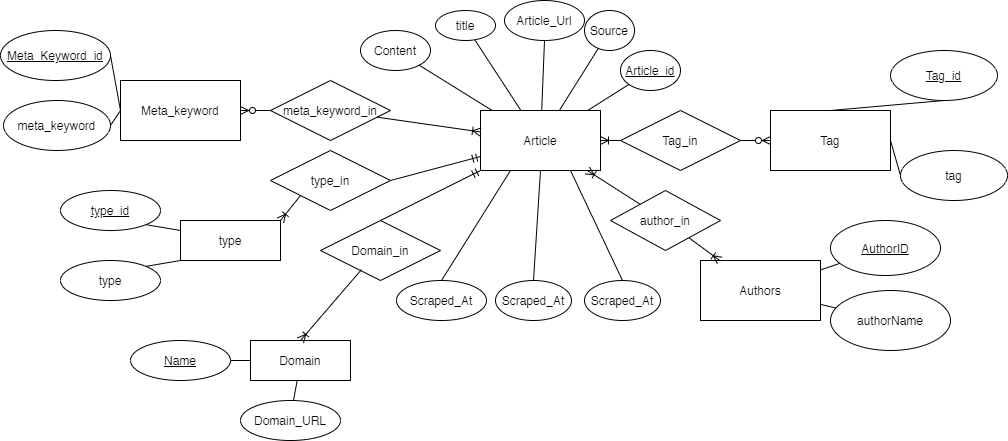

In [4]:
# importing Image class from PIL package  
from PIL import Image  
  
# creating a object  
im = Image.open(r"..\ER_Diagram.png")  

im

SQL koden som blev brugt til at lave databasen er i filen "SQL_database.sql". Vi har valgt at meta_keyword, type, domain, authors og tag ikke er atributes på article, men istedet
har deres egne tables. Så i table´et 'type' er der 11 typer som hvber har deres id, fordi 'type' er en one-to-many relation bliver det id gemt i article. Hvor tag er en many-to-may
relation derfor har vi lavet et relation table som gemmer tags som høre til artiklerne. I dette relation table gemmer vi id´et på artiklen og på tag´et. De andre one-to-many og
many-to-many virker på samme måde.

Koden som vi har brugt til opdele databasen og røde op i data´et kan ses i filerne 'Clean.ipynb' og 'Organize.ipynb'. Hvor clean rydder i artiklers content, og organize opdeler 
artiklerne i forskellige csv filer som vi populate´er vores database med.

In [ ]:
def execQuery(query):
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "root",
                                      host = "localhost",
                                     port = "5432",
                                      database = "postgres")
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

# Opgave 3

## Opgave 3.1

For at løse opgave 3.1 har vi lavet to queries, en med og uden INNER JOIN. Vi gemmer vores sraped_at dato´er som Dates så vi kan bruge >= oprationen til at finde de artikler som er
blevet scrapet efter 15. Jan 2018. Derefter finder vi kun de artikler som har type_id = 4, dette er for kun finde artikler som er 'reliable'.

In [ ]:
SELECT domain_name.domain_name FROM domain_name
WHERE domain_id in (SELECT article.domain_id FROM article
WHERE article.type_id = '4' and scraped_at >= '2018-01-15')

Eller

In [ ]:
SELECT DISTINCT domain_name.domain_name FROM domain_name
INNER JOIN article
ON article.domain_id = domain_name.domain_id
WHERE article.type_id = '4' and scraped_at >= '2018-01-15'

## Opgave 3.2

Med denne query finder vi den author med flest fake new artikler. Dette gør vi ved at sortere fra størst til mindst og derefter sætter en limit på en hvilket kun giver det største
element. Hvis der er 2 authros som har skrevet lige mange fake news artikler vil den stadig kun give en author.

In [ ]:
SELECT COUNT(author_in.authorid), author.authorname
FROM author_in
INNER JOIN author
ON author.authorid = author_in.authorid
WHERE author_in.id in (SELECT article.id FROM article WHERE article.type_id = 1)
GROUP BY author_in.authorid, author.authorname
ORDER BY COUNT(author_in.authorid) DESC
LIMIT 1

## Opgave 3.3

Måden vi har talt par på er ved at sige hvis 3 artikler (a, b, c) har de samme meta_tags så laver det parene (a, b) og (a, c) og vi tæller ikke (b, c) med 
fordi det kan man antage med de andre par. Så antallet af par er Count(*) - 1 som kan ses på linje 2
Måden den virker på er ved at den kollapser alle metatags med artiklerne så meta_tagsene bliver gemt som en liste istedet for flere forskellige rows. Dette gør vi med aggrations
funktionen 'array_agg'. Derefter kollapser vi alle artikel id´erne som har den samme liste af meta_tags, med samme 'array_agg' og hvis længden af listen er mere end 1
er der 1 eller flere par. Tilsidst tager vi summen af alle parene hvilket giver det totale antal par artikler som har de samme meta_tags.

In [ ]:
SELECT sum(pairAmount)
FROM (SELECT count(*) - 1 as pairAmount
	FROM (SELECT id, array_agg(meta_keywords.meta_keyword) AS Meta_Keyword_ids
			FROM meta_keywords_in
			INNER JOIN meta_keywords
			ON meta_keywords.meta_keyword_id = meta_keywords_in.meta_keyword_id
			WHERE meta_keywords.meta_keyword_id != '137'
			GROUP BY meta_keywords_in.id
		 ) meta_keywords_in
	GROUP BY Meta_Keyword_ids
	HAVING count(*) > 1) AS counter

# Assignment 5

I this task we had to make a web crawler that could scrape information from "Politics and Conflict" on Wikinews and based on our group number we would should only select a subset of all articles. This was given to us in the form of some python code to generate a string with the beginning letter for articles within our subset of articles.

The first step we took was to figure out what kind of task we were given before we decided on a given tool.

The first few observations we made were regarding how the webpage indexed its articles such that we could make our crawling logic.

The first observation we made was that each "entry point" for a given letter was easy to get as it was just https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&from=[letter], where the letter was at the end of the url. on a given entry point there are links to categories and articles however there are a maximum 200 pages, even if there are more articles with a given starting letter, so we had to follow links to find all articles. A stiking(maybe wrong word) point arose when we looked at "indexing"-urls after our entry points as they had no information of what letter/entry point we were coming from as they where of the form https://en.wikinews.org/w/index.php?title=Category:Politics_and_conflicts&pagefrom=[start article]+[end article], such that the url only described by article tiles what other articles where on that indexing page. This mean that our tool had to be able to follow links and have knowledge of what page it was coming from as it could nut just use information on a page as well as jumping to all articles on an indexing page.

Next we looked at a few articles and they seemed to have a general structure such that locating them on a page within html would be somewhat doable so we postponed the actual scraping part for later.

Because of the requirements based on our initial exploration of the problem(might be bad wording) and our look at python web scraping tools we choose Scrapy as it is a feature rich tool made for making web crawlers and as we had some requirements that where non trivial ie. traversal logic more complicated then get all links and so on we choose it.

When implementing our scraper we had a lot obstacles a long the way aplified by the fact that we assigned tasks such that people with less explerience i an given subject had to do it for our assignment.

We started by reading documentation while watching and reading tutorials as we building a dummy spider for a smaller part of the problem to get the basics of Scrapy right as well as understading HTML-markup node navigation. we made use of xpath to locate nodes within HTML. A snapshot of our Scrapy class we made is given below:



In [3]:
import pandas as pd


In [40]:
filepath = '/home/daniel/OneDrive/KUuni/DataScience/Python/DS_5/wiki_news_nr_12.csv'

# we read in the file
df = pd.read_csv(filepath)

# print shape -< how many rows and elements it has
print(df.shape, "<- shape of wikinews-dataset(row, col)")

# how many unique urls did we get(optimally as many as the rows in our dataframe)
unique_articles = df['article_url'].unique().shape
print(unique_articles, "<- num of unique articles - seems to have the same number of rows no duplicates")

# how many fields without daata ie. nan out of all fiels
df_nan_elms = df.isna().sum().sum()
df_not_nan_elms = df.notna().sum().sum()
print( df_nan_elms, "<- num of nan entries out of ->",  df_not_nan_elms ,
     "\nnan rate of", df_nan_elms/df_not_nan_elms, "%")
# majority comes form articles not having sources or source wiki pages
print(df['sources_url'].isna().sum(), "nan elements from sources_url column")
print( df['about_sources_wiki_url'].isna().sum(), "nan elements from about_sources_wiki_url column\n")
print(df.info())

(3680, 8) <- shape of wikinews-dataset(row, col)
(3680,) <- num of unique articles - seems to have the same number of rows no duplicates
437 <- num of nan entries out of -> 29003 
nan rate of 0.01506740681998414 %
216 nan elements from sources_url column
210 nan elements from about_sources_wiki_url column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   article_url             3680 non-null   object
 1   categories              3680 non-null   object
 2   content                 3678 non-null   object
 3   publish_date            3671 non-null   object
 4   scraped_at              3680 non-null   object
 5   sources_url             3464 non-null   object
 6   about_sources_wiki_url  3470 non-null   object
 7   title                   3680 non-null   object
dtypes: object(8)
memory usage: 230.1+ KB
None


This test spider below was used to see of we could iterate over a list of article-URLs if we could locate them on a navigation page. This early spider has 2 parts only, one for iterating over URLs and the other for getting article scraping data. The spider above worked fine but the next step being creating the navigation logic became the biggest hurdle caused by a simple ting. We wrote the spider logic for another website as it was simpler and adapted it to wikinews, however when we interchanged our other website with wikinews no files where generated when we selected to get output. After debugging we came across an Error about robot.txt which tunrns out is used when accesing websites from non-intruductionary-tutorials as it is a policy obayed by all never Scrapy spider by default if a website dosen't allow certain kinds of scrapers. After this we changed our spider to not obay the robot.txt but read https://en.wikipedia.org/robots.txt and implimented restrictions on the spider as to not be more fair to the website as we. Below the test spider we have included some of the settings we enabled to scrape more responsibly


In [ ]:
``` Test spider - bash
class testSpider(scrapy.Spider):
    name = "test"
    def start_requests(self):
        urls = [
            'https://en.wikinews.org/wiki/A_policeman_is_killed_and_another_one_is_tortured_in_MST_camp,_in_Brazil',

            'https://en.wikinews.org/wiki/African_Union_refuses_to_arrest_Sudan%27s_President_for_war_crimes',
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)

    # get article content
    def parse(self, response):
        for info in response.xpath('//div[@id="content"]'):
            yield {
                'title': info.xpath('//*[@id="firstHeading"]/text()').get(),
            }



``` Settings - python
AUTOTHROTTLE_ENABLED = True
# The initial download delay
AUTOTHROTTLE_START_DELAY = 5
# The maximum download delay to be set in case of high latencies
AUTOTHROTTLE_MAX_DELAY = 30
# The average number of requests Scrapy should be sending in parallel to
# each remote server
AUTOTHROTTLE_TARGET_CONCURRENCY = 1.0
# Enable showing throttling stats for every response received:

# Enable and configure HTTP caching (disabled by default)
HTTPCACHE_ENABLED = True
```

